## 问答题
1. 支持向量机的基本思想是什么？

2. 什么是支持向量？

3. 在使用 SVM 时，缩放输入值为什么很重要？

4. SVM 分类器在对实例进行分类时能输出置信度分数吗？概率呢？

5. 你如何在 LinearSVC、SVC 和 SGDClassifier 之间进行选择？

6. 假设你已经使用 RBF 核训练了一个 SVM 分类器，但它似乎欠拟合训练集。
   你应该增大还是减小 γ（gamma）？C 呢？

7. ε 不敏感模型是什么意思？

8. 使用核技巧有什么意义？

## 编程题
1. 在葡萄酒数据集上训练SVM分类器，可以使用sklearn.datasets.load_wine()加载它。该数据集包含3个不同种植者生产的178个葡萄酒样本的化学分析：目标是训练一个分类模型，该模型能够根据葡萄酒的化学分析预测种植者。由于SVM分类器是二元分类器，将需要使用“一对全部”对所有三个类进行分类。能达到的精度是多少？

   "一对全部"可以复习 **8_sklearn做分类.ipynb**里的笔记，里面提到了用二元分类器做多分类问题

---

2. 提前预习 **10_支持向量机.ipynb** 最新更新的笔记 （把SVM分类用梯度下降实现）； 大概理解笔记后，尝试自己对照笔记 实现用梯度下降实现SVM分类

   并把自定义的SVM分类用于 iris data(鸢尾花数据)； 取花瓣长度 和 花瓣宽度特征， 分类 看是不是 分类2的花 （(iris.target == 2)

   对比下sklearn自带的SVM分类 和 自定义SVM分类 实现的分类效果



In [18]:
# 1. 加载数据
from sklearn.datasets import load_wine

wine = load_wine()
X = wine.data
y = wine.target

In [19]:
# 2. 数据分割（训练集 + 测试集）
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [20]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
svm = Pipeline([('scaler',StandardScaler()), ('svc',SVC())])

In [21]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

param_grid = {
    'svc__C': [0.1, 1, 10, 100],
    'svc__gamma': ['scale', 'auto', 0.001, 0.01, 0.1],
    'svc__kernel': ['linear', 'rbf']
}
grid = GridSearchCV(svm, param_grid, cv=5, scoring='accuracy')
grid.fit(X_train, y_train)

best_svm = grid.best_estimator_
y_pred = best_svm.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"最佳参数: {grid.best_params_}, 测试集准确率: {accuracy:.4f}")

最佳参数: {'svc__C': 1, 'svc__gamma': 0.01, 'svc__kernel': 'rbf'}, 测试集准确率: 1.0000


In [37]:
from sklearn.base import BaseEstimator
import numpy as np

class MyLinearSVC(BaseEstimator):
    def __init__(self, C, eta0, n_epochs=1000, random_state=None):
        self.C = C
        self._alpha = 1 / (2*C)
        self.eta0 = eta0
        self.n_epochs = n_epochs
        self.random_state = random_state

    @property
    def eta(self):
        return self.eta0

    def fit(self, X, y):
        # 随机初始化，可以联系到为什么很多类 会有 random_state这个参数
        if self.random_state:
            np.random.seed(self.random_state)

        m, n= X.shape
        w = np.random.randn(n, 1)  # n 个 特征权重
        b = 0.0
        t = np.array(y, dtype=np.float64).reshape(-1, 1) * 2 - 1  # 把 分类 0 和 分类 1 转成  分类-1 和分类 1
        self.Js = []   # 损失值列表

        # 训练
        for epoch in range(self.n_epochs):
            support_vectors_idx = ((X@w + b)*t < 1).ravel()   # 找出支持向量 （损失值不为0的训练集实例， 当前街道内部/分类错误的训练集实例）
            X_sv = X[support_vectors_idx]
            t_sv = t[support_vectors_idx]

            J = (np.sum(w * w) * self._alpha +  np.sum(1- t_sv * (X_sv@w + b))) / m
            self.Js.append(J)

            w_gradient_vector = (2*self._alpha*w  - X_sv.T @ t_sv) / m
            b_derivative = - np.sum(t_sv) / m

            w = w - self.eta * w_gradient_vector
            b = b - self.eta * b_derivative



        self.intercept_ = b
        self.coef_ = w
        support_vectors_idx = ((X@w + b)*t < 1).ravel()
        self.support_vectors_ = X[support_vectors_idx]
        return self

    def decision_function(self, X):
        return X.dot(self.coef_) + self.intercept_

    def predict(self, X):
        return self.decision_function(X) >= 0

In [38]:
from sklearn.pipeline import make_pipeline
from sklearn.datasets import load_iris
from sklearn.svm import LinearSVC,SVC
iris = load_iris(as_frame=True)
X = iris.data[["petal length (cm)", "petal width (cm)"]].values
y = iris.target == 2
C = 1
my_linearSVC = make_pipeline(StandardScaler(), MyLinearSVC(C=C, eta0 =0.05, n_epochs=5000, random_state=42))
my_linearSVC.fit(X, y)

linear_svc = make_pipeline(StandardScaler(), LinearSVC(loss="hinge", C=C, dual=True, random_state=42))
linear_svc.fit(X, y)

svc = make_pipeline(StandardScaler(), SVC(kernel="linear", C=C, tol=1e-4,random_state=42))
svc.fit(X, y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc',
                 SVC(C=1, kernel='linear', random_state=42, tol=0.0001))])

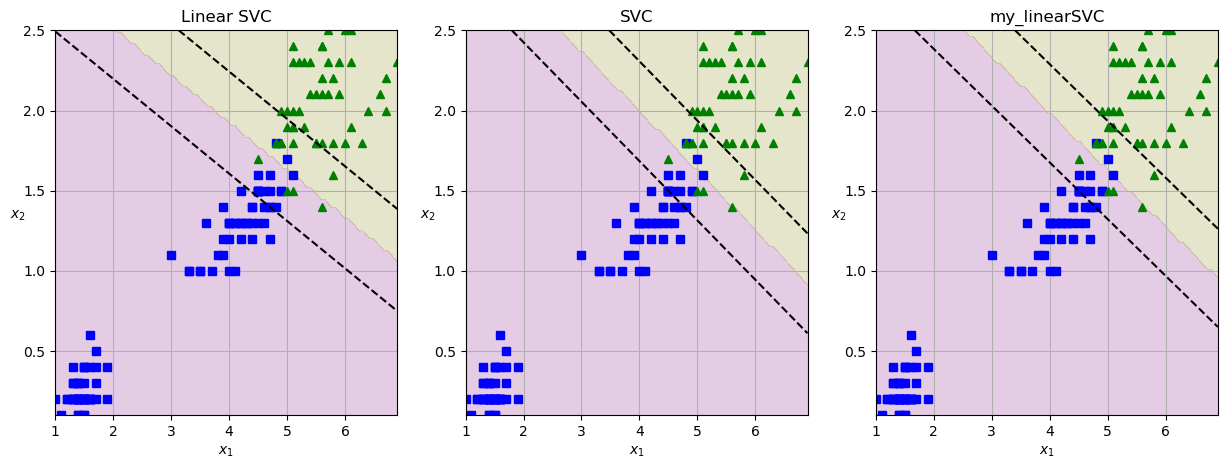

In [39]:
from matplotlib import pyplot as plt
def plot_dataset(X, y, axes):
    # axes： 坐标轴的范围，列表
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")
    plt.axis(axes)
    plt.grid(True)
    plt.xlabel("$x_1$")
    plt.ylabel("$x_2$", rotation=0)

def plot_predictions(clf, axes):
    # axes: 坐标轴的范围，列表, [x上界，x下界, y轴上界,y轴下界]
    x0s = np.linspace(axes[0], axes[1], 100)
    x1s = np.linspace(axes[2], axes[3], 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    X = np.c_[x0.ravel(), x1.ravel()]
    y_pred = clf.predict(X).reshape(x0.shape)                     # y_pred.shape: (100,100)  里面全都是预测的分类
    y_decision = clf.decision_function(X).reshape(x0.shape)       # y_decision.shape:(100,100) 里面全都是预测的分数（相对于决策线的距离）
    plt.contourf(x0, x1, y_pred, cmap=plt.cm.brg, alpha=0.2)  # 根据每个网格点的预测分类（+1 或 -1），用不同颜色填充区域。颜色分界线就是 SVM 的分类边界。
    # plt.contourf(x0, x1, y_decision, cmap=plt.cm.brg, alpha=1)
    plt.contour(x0, x1, y_decision, levels=[-1, 1], colors='k', linestyles=['--',  '--']) # 画间隔，间隔 根据决策分数=+1/-1决定

axes = [np.min(X[:,0]), np.max(X[:, 0]), np.min(X[:, 1]),np.max(X[:,1])]
plt.figure(figsize=(15, 5))
plt.subplot(1,3,1)
plot_dataset(X,y, axes)
plot_predictions(linear_svc, axes=axes)
plt.title("Linear SVC")

plt.subplot(1,3,2)
plot_dataset(X,y, axes)
plot_predictions(svc, axes=axes)
plt.title("SVC")

plt.subplot(1,3,3)
plot_dataset(X,y, axes)
plot_predictions(my_linearSVC, axes=axes)
plt.title("my_linearSVC")
plt.show()